In [1]:
import pandas as pd
import json

import matplotlib.pyplot as plt

In [2]:
with open('sit-ups03.json', 'r') as json_file:
    data = json.load(json_file)

In [3]:
data = pd.json_normalize(data)

In [4]:
data.head()

,accuracy,data,experimentId,patientId,sensorId,sensorType,timestamp
0,3,"[0.13998012, 4.959424, 9.529716]",0,0,LSM6DSO Accelerometer,1,3114357777961892
1,3,"[-0.2661767, -0.6666634, -0.59076566]",0,0,LSM6DSO Gyroscope,4,3114357785170433
2,3,"[-0.009571291, 4.7727838, 9.969097]",0,0,LSM6DSO Accelerometer,1,3114357758545121
3,3,"[-0.09332009, 4.694718, 10.000204]",0,0,LSM6DSO Accelerometer,1,3114357739128454
4,3,"[-0.28236416, -0.66849595, -0.5803813]",0,0,LSM6DSO Gyroscope,4,3114357804587308


sensorId
LSM6DSO Accelerometer                 666
LSM6DSO Gyroscope                     663
LSM6DSO Gyroscope-Uncalibrated         63
LSM6DSO Accelerometer-Uncalibrated     63
linear_acceleration                    62
Name: count, dtype: int64


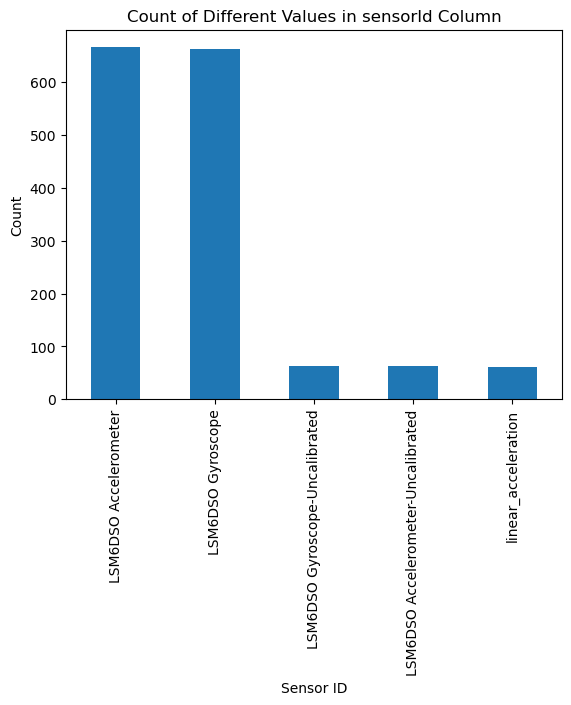

In [5]:
sensor_counts = data['sensorId'].value_counts()

# Print the sensor counts (optional)
print(sensor_counts)

# Plot the sensor counts
sensor_counts.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Sensor ID')
plt.ylabel('Count')
plt.title('Count of Different Values in sensorId Column')

# Show the plot
plt.show()



In [12]:
# Filter the DataFrame for 'icm4x6xx Accelerometer Non-wakeup' in the 'sensorType' column
df = data[data['sensorId'] == 'LSM6DSO Accelerometer']

df.head()

,accuracy,data,experimentId,patientId,sensorId,sensorType,timestamp
0,3,"[0.13998012, 4.959424, 9.529716]",0,0,LSM6DSO Accelerometer,1,3114357777961892
2,3,"[-0.009571291, 4.7727838, 9.969097]",0,0,LSM6DSO Accelerometer,1,3114357758545121
3,3,"[-0.09332009, 4.694718, 10.000204]",0,0,LSM6DSO Accelerometer,1,3114357739128454
5,3,"[0.16031912, 4.8708897, 8.889337]",0,0,LSM6DSO Accelerometer,1,3114357797378871
8,3,"[0.18185452, 4.453043, 8.773284]",0,0,LSM6DSO Accelerometer,1,3114357855629340


C:\Users\aiskr\AppData\Local\Temp\ipykernel_22452\4277805894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
C:\Users\aiskr\AppData\Local\Temp\ipykernel_22452\4277805894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x', 'y', 'z']] = pd.DataFrame(df['data'].tolist(), index=df.index)


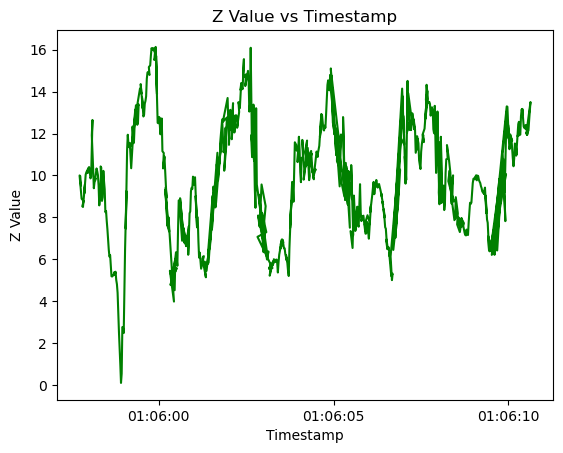

In [15]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract 'x', 'y', 'z' values from the 'data' column
df[['x', 'y', 'z']] = pd.DataFrame(df['data'].tolist(), index=df.index)

# Create df_sensor with the desired columns
df_sensor = df[['timestamp', 'x', 'y', 'z']]

plt.plot(df_sensor['timestamp'], df_sensor['z'], linestyle='-', color='g')
# Set plot labels and title
plt.xlabel('Timestamp')
plt.ylabel('Z Value')
plt.title('Z Value vs Timestamp')

# Show the plot
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

In [17]:
# Combine x, y, z into a single signal (e.g., magnitude)
df_sensor['magnitude'] = np.sqrt(df_sensor['x']**2 + df_sensor['y']**2 + df_sensor['z']**2)

C:\Users\aiskr\AppData\Local\Temp\ipykernel_22452\219995185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor['magnitude'] = np.sqrt(df_sensor['x']**2 + df_sensor['y']**2 + df_sensor['z']**2)


In [39]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Parameters for the low-pass filter
cutoff_frequency = 1.0  # Cutoff frequency in Hz
sampling_rate = 3   # Sampling rate in Hz (adjust based on your data)
order = 4              
# Apply the filter to the magnitude signal
df_sensor['filtered_magnitude'] = butter_lowpass_filter(df_sensor['magnitude'], cutoff_frequency, sampling_rate, order)

KeyError: '[18, 64, 107, 281, 323, 373] not in index'

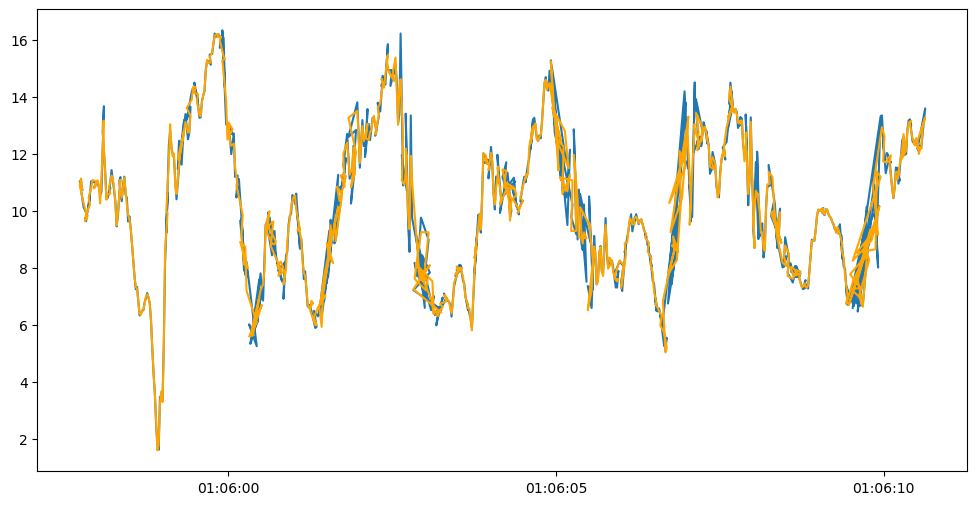

In [31]:
# Find peaks in the filtered signal
peaks, _ = find_peaks(df_sensor['filtered_magnitude'], height=3, distance=40)

# Plot the original and filtered signals with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(df_sensor['timestamp'], df_sensor['magnitude'], label='Original Signal')
plt.plot(df_sensor['timestamp'], df_sensor['filtered_magnitude'], label='Filtered Signal', color='orange')
plt.plot(df_sensor['timestamp'][peaks], df_sensor['filtered_magnitude'][peaks], 'rx', label='Detected Peaks')
plt.xlabel('Timestamp')
plt.ylabel('Magnitude')
plt.title('Sit-up Detection from Sensor Data')
plt.legend()
plt.show()

KeyError: "None of [Index([18, 28, 58, 95, 105, 129, 147, 182, 206, 232, 279, 299, 331, 346], dtype='int64')] are in the [index]"

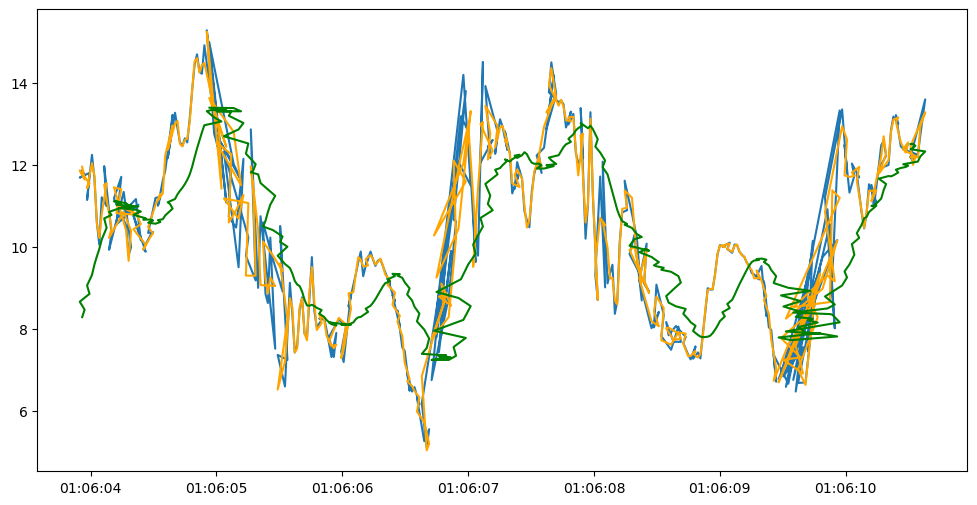

In [41]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Parameters for the moving average filter
window_size = 20  # Adjust based on your data

# Apply the moving average filter to the filtered signal
df_sensor['smoothed_magnitude'] = moving_average(df_sensor['filtered_magnitude'], window_size)

# Drop NaN values resulted from the moving average
df_sensor = df_sensor.dropna(subset=['smoothed_magnitude'])
# Find peaks in the smoothed signal
peaks, _ = find_peaks(df_sensor['smoothed_magnitude'], height=0.5, distance=10)

# Plot the original, filtered, and smoothed signals with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(df_sensor['timestamp'], df_sensor['magnitude'], label='Original Signal')
plt.plot(df_sensor['timestamp'], df_sensor['filtered_magnitude'], label='Filtered Signal', color='orange')
plt.plot(df_sensor['timestamp'], df_sensor['smoothed_magnitude'], label='Smoothed Signal', color='green')
plt.plot(df_sensor['timestamp'][peaks], df_sensor['smoothed_magnitude'][peaks], 'rx', label='Detected Peaks')
plt.xlabel('Timestamp')
plt.ylabel('Magnitude')
plt.title('Sit-up Detection from Sensor Data')
plt.legend()
plt.show()